In [1]:
# This notebook is to practice feature reduction techniques on the 
# sklearn covtypes dataset.  I will only be dealing with the continuous 
# features
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
covtype = fetch_covtype(as_frame=True)
X = covtype['data']
y = covtype['target']
feature_names = covtype['feature_names']
num_feats =  feature_names[:10]
cat_feats = feature_names[10:]

In [3]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, random_state=42)

In [4]:
pipe_lda_reduce = Pipeline([
    ('scaler', StandardScaler()),
    ('lda', LinearDiscriminantAnalysis(n_components=2))
])
X_reduced_lda = pd.DataFrame(pipe_lda_reduce.fit_transform(X_train, y_train))
X_reduced_lda.rename(columns={0:"var1", 1:"var2"}, inplace=True)
X_reduced_lda['covtype'] = y_train.values

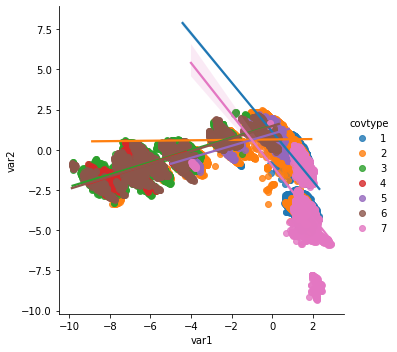

In [5]:
# It seems that for a given value of var1 and var2, there are usually about 
# 3 covtypes that would be possible.  This is not great seperation.
sns.lmplot(data=X_reduced_lda, x='var1', y='var2', hue='covtype')

In [6]:
pipe_pca_reduce = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2))
])
X_reduced_pca = pd.DataFrame(pipe_pca_reduce.fit_transform(X_train))
X_reduced_pca.rename(columns={0:'var1', 1:'var2'}, inplace=True)
X_reduced_pca['covtype'] = y_train.values

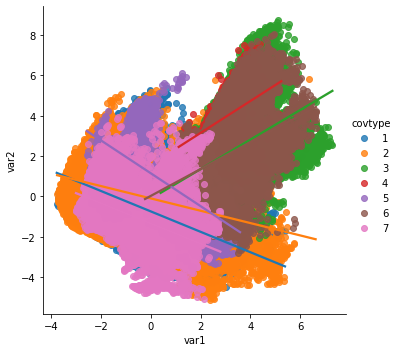

In [7]:
# When using pca, everthing is more in one central glob compared to the 
# smaller subgroups generated by lda.  Because of this, there are more
# var1 and var2 combinations that could belong to more than 3 classes, 
# so this might be the worse of the two dimensionality reduction tecniques
# for this dataset.
sns.lmplot(data=X_reduced_pca, x='var1', y='var2', hue='covtype')

In [8]:
# Now that we have visualized how seperable the training data is when 
# applying lda and pca, lets train lda model on the train set and see
# how it performs on the test set.  Similarly, I will fit a pca on the train
# data and train a logistic regression model on the resulting features.  I 
# will then see how the resulting model performs on the test data.

In [9]:
# Lets examine what scores we will get if we apply use a qda model to 
# predict the covtype of the standard scaled numeric features.  Our mean
# cv score is just under 69%.
pipe_lda = Pipeline([
    ('scaler', StandardScaler()),
    ('lda', LinearDiscriminantAnalysis())
])
pipe_lda.fit(X_train[num_feats], y_train)
lda_scores = cross_val_score(pipe_lda, X_test[num_feats], y_test, cv=5)
print('mean_score: ', np.mean(lda_scores), '\ncv_scores: ', lda_scores)

mean_score:  0.6876277581991098 
cv_scores:  [0.6891329  0.69095728 0.68803139 0.6854389  0.68457831]


In [23]:
# As expected, the two variables generated from PCA perform even more poorly
# than a lda model for the numerical features.
from sklearn.linear_model import LogisticRegression
pipe_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2))
])
clf = LogisticRegression()
clf.fit(pipe_pca.fit_transform(X_train[num_feats]), y_train)
pca_scores = cross_val_score(
    clf, pipe_pca.transform(X_test[num_feats]), y_test, cv=5)
print('mean_score: ', np.mean(pca_scores), '\ncv_scores: ', pca_scores)

mean_score:  0.48344613754515997 
cv_scores:  [0.48208323 0.48208323 0.4843551  0.48578313 0.48292599]
